# Convolutional Neural Network (CNN; 합성곱 신경망)

## CNN 개념

이미지는 최소 2차원 이상의 차원을 가집니다.  
이것을 1차원으로 펼치고 (flatten) MLP로 연결하는 이전 예제의 방식은 이미지 인식에 있어서 큰 한계가 있습니다.  

이미지의 2D 이상의 공간적 정보를 유지한 채 효율적이고 효과적인 인식을 하기 위한 인공신경망 구조가 바로 CNN 입니다.  

요즘은 Transformer가 전통적인 CNN 구조를 일부 대체하기도 하지만, 이미지 인식과 관련된 많은 현업 프로젝트에서 CNN은 크게 활약하고 있습니다.  

꼭 이미지 인식만이 아니더라도 이상 신호 탐지, 음성/소리 인식 등에 있어서도 CNN은 다양하게 활용되고 있습니다.  


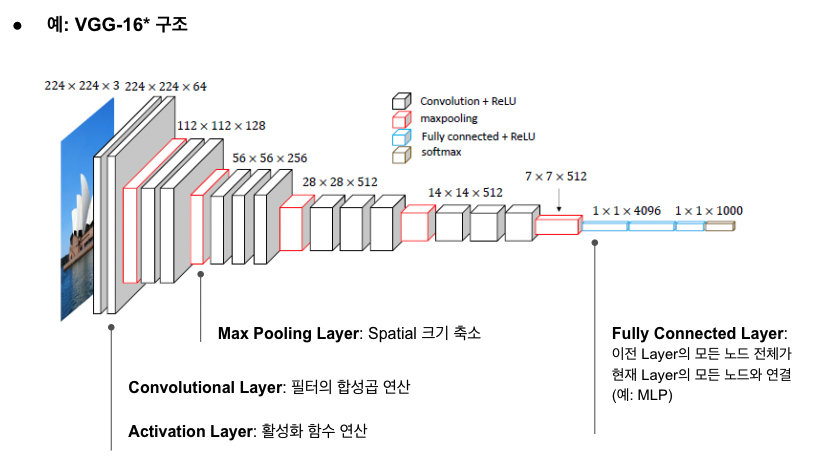

위 그림은 CNN 신경망의 기본적인 연산으로만 구성된 가장 단순한 구조의 CNN 중 하나인 VGG Net입니다.  

{{ Convolution -> Activation } (x n) -> Max Pooling } (x m) -> Fully-Connected (x l) -> Softmax Output  순서로 구성되어 있습니다.  


### Convolutional Layer  (합성곱 층)

합성곱 필터에 의해 합성곱 연산이 일어납니다.  
(합성곱 연산: 필터와 겹치는 부분의 데이터와 필터값을 곱해서 모두 더한다)  

이 합성곱 필터가 2D 평면 상에서 슬라이딩 하면서 연산을 수행하여 다음 레이어의 특성맵 (feature map)을 만듭니다. 이를 2D Convolution 이라고 합니다.  


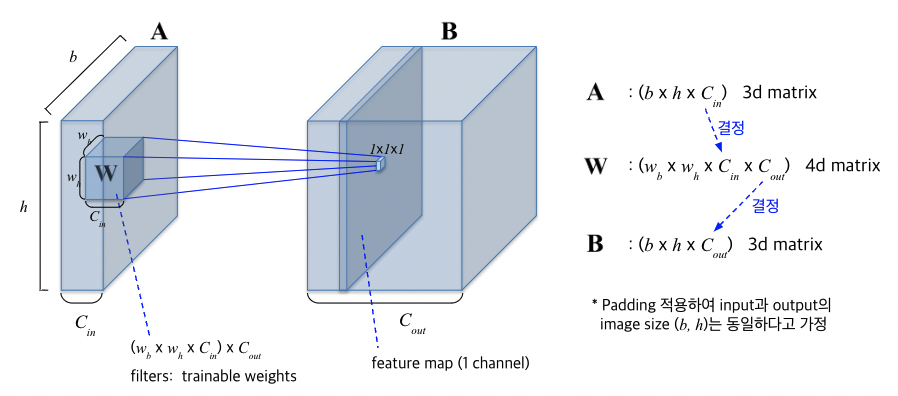

### Max Pooling Layer

보통 CNN 신경망 중간중간에 풀링 층을 통해 특성맵의 공간 사이즈를 줄입니다.  
메모리 크기를 줄이고 계산량을 줄이는 역할 외에도, 중요한 정보만 남기고 추상화 하는 역할도 담당합니다.  
따라서 이를 통해 과적합(overfitting)이 완화됨을 의미하기도 합니다.  


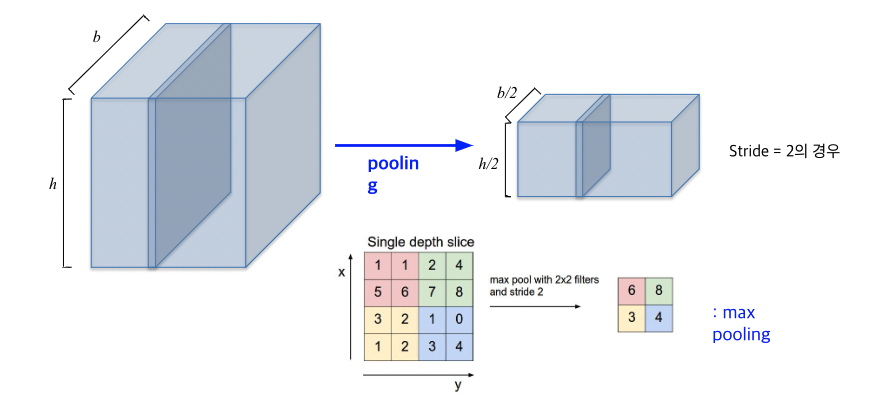

## CNN 예제 1 - Fashion MNIST

지난 시간에 MLP를 통해 다뤄봤던 Fashion MNIST를 이번엔 CNN을 사용하여 인식시켜 보겠습니다.  

정확도에 변화가 있는지 비교해 보시기 바랍니다.  


### Fashion MNIST 데이터 로드 (데이터셋 & 데이터로더)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


batch_size = 64

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)


test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
for X,y in train_dataloader:
    print(X.shape)
    break

torch.Size([64, 1, 28, 28])


### CNN 모델 정의

CNN 모델을 정의합니다.  
Convolution layer 2개와 Max Pooling layer 2개를 가지는 매우 간단한 형태의 CNN 모델을 만들어 보겠습니다.  

학습 및 테스트 함수도 여기서 정의하겠습니다.  


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)   # 1ch -> 4ch, 5x5 filter
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 5)   # 4ch -> 8ch, 5x5 filter
        self.fc1 = nn.Linear(8 * 4 * 4, 40)
        self.fc2 = nn.Linear(40, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # 1ch x 28 x 28 -> 4ch x 24 x 24
        x = self.pool(x)            # 4ch x 24 x 24 -> 4ch x 12 x 12
        x = F.relu(self.conv2(x))   # 4ch x 12 x 12 -> 8ch x 8 x 8
        x = self.pool(x)            # 8ch x 8 x 8 -> 8ch x 4 x 4
        x = x.view(-1, 8 * 4 * 4)
        x = F.relu(self.fc1(x))     # 128 -> 40
        x = self.fc2(x)             # 40 -> 10
        return x


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()

    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=10, bias=True)
)


### 학습하기

위에서 정의한 CNN 모델을 생성하고 학습을 진행해 봅니다.  


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

net = Net()
net = net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

epochs = 20

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, net, loss_fn, optimizer)
    test(test_dataloader, net, loss_fn)

print("Done!")


Epoch 1
-------------------------------
loss: 2.303483  [    0/60000]
loss: 0.999134  [ 6400/60000]
loss: 0.580260  [12800/60000]
loss: 0.750347  [19200/60000]
loss: 0.760855  [25600/60000]
loss: 0.646982  [32000/60000]
loss: 0.657337  [38400/60000]
loss: 0.560386  [44800/60000]
loss: 0.657492  [51200/60000]
loss: 0.584809  [57600/60000]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.611122 

Epoch 2
-------------------------------
loss: 0.575821  [    0/60000]
loss: 0.569960  [ 6400/60000]
loss: 0.369933  [12800/60000]
loss: 0.621135  [19200/60000]
loss: 0.667329  [25600/60000]
loss: 0.536835  [32000/60000]
loss: 0.522761  [38400/60000]
loss: 0.540895  [44800/60000]
loss: 0.627736  [51200/60000]
loss: 0.470110  [57600/60000]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.529495 

Epoch 3
-------------------------------
loss: 0.470534  [    0/60000]
loss: 0.488511  [ 6400/60000]
loss: 0.322205  [12800/60000]
loss: 0.536402  [19200/60000]
loss: 0.600692  [25600/60000]
loss: 0.520777  [32000/600

### 평가하기

테스트 데이터에 대해 정확도와 Confusion Matrix를 구해 보겠습니다.  


테스트 정확도: 86.39 %


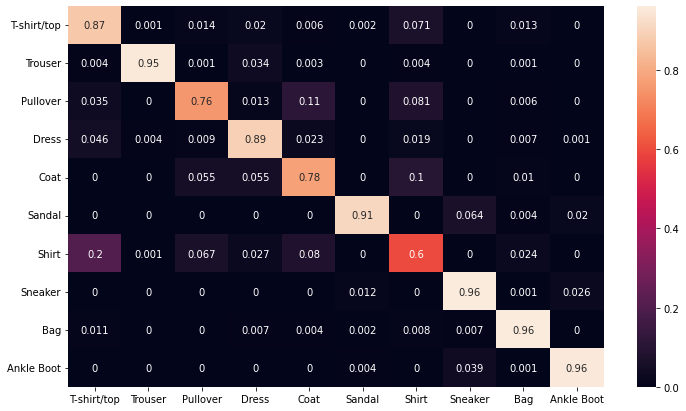

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np


y_pred = []
y_true = []

net.eval()

# 테스트 및 결과 저장
for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    output = net(inputs)

    output = output.argmax(1).detach().cpu().numpy()
    y_pred.extend(output) # 예측치 저장
    
    labels = labels.detach().cpu().numpy()
    y_true.extend(labels) # 정답값 저장


# 정확도 계산
accuracy = (np.array(y_pred) == np.array(y_true)).mean()
print('테스트 정확도:', accuracy * 100, '%')


## confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()


지난번 학습시켰던 MLP와 결과를 비교해 보세요.  
   
   
---

## CNN 예제 2 - CIFAR-10, Transfer Lerning

또 다른 예제로 CIFAR-10 데이터셋을 이용한 이미지 분류를 실습해 보겠습니다.  
CIFAR-10 데이터셋은 32x32x3의 컬러 이미지가 입력으로 주어지고, 10종의 사물/동물로 분류합니다.  

이미지 인식 문제이므로 마찬가지로 CNN을 사용하는데, 여기서는 사전학습된 VGG16 네트워크를 가져와서 Fine Tuning 하는 것을 실습합니다. 

### CIFAR-10 데이터 로드

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100


# 학습용 데이터
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)


# 테스트용 데이터
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print(trainset)
print(testset)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


이제 데이터를 눈으로 확인해 보겠습니다.

<class 'torch.Tensor'> torch.Size([100, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([3, 70, 138])


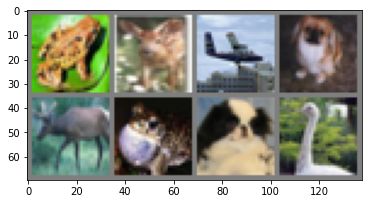

      frog       deer      plane        dog
      deer       frog        dog       bird


In [ ]:
# 이미지 가시화 함수 구현
def imshow(img):
    img = img / 2 + 0.5     # 역정규화
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 채널을 맨 마지막으로


# 학습용 이미지 1 batch 추출 (랜덤)
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images), images.shape)
print(type(labels), labels.shape)


# 이미지를 그리드로 배치
grid_image = torchvision.utils.make_grid(images[:8, ...], nrow=4)
print(type(grid_image), grid_image.shape)


# 이미지 그리기
imshow(grid_image)
plt.show()


# 라벨(정답) 프린트
print(' '.join(['%10s' % classes[labels[j]] for j in range(4)]))
print(' '.join(['%10s' % classes[labels[j]] for j in range(4,8)]))


### CNN 모델 준비

torchvision에서는 데이터셋 뿐만 아니라 여러 CNN 모델들도 제공합니다.  
여기서는 VGG16 모델을 사용해 보겠습니다.  
이 때에 사전학습된 가중치도 함께 로드하도록 하겠습니다.  


In [ ]:
# VGG16 모델
net = torchvision.models.vgg16(pretrained=True)
print('변경 전')
print(net)


# 출력 레이어의 노드 수를 1000개 --> 10개로 수정
input_lastLayer = net.classifier[6].in_features
net.classifier[6] = nn.Linear(input_lastLayer, 10)
print('-' * 100)
print('변경 후')
print(net)


# GPU에 탑재
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = net.to(device)


# 손실함수(loss function)와 최적화 함수(optimization function) 선언
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


변경 전
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

### 학습하기

사전학습은 다른 데이터셋(ImageNet)에 대해 이루어졌기 때문에 CIFAR-10에 맞게 Fine Tuning이 이루어져야 합니다.  
이를 Transfer Learning, 즉 전이학습이라고도 합니다.  

Fine Tuning에서는 초반 레이어의 가중치를 고정하고 후반 레이어의 가중치만을 학습시키는 경우도 있지만, 여기서는 모든 가중치에 대해 학습을 수행해 보겠습니다.  


In [ ]:
epoch = 5
interval = 100

for t in range(epoch):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):

        inputs, labels = inputs.to(device), labels.to(device)

        # gradient 초기화
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache()

        # print statistics
        running_loss += loss.item()
        if i % interval == interval - 1:
            print('[%d, %5d] loss: %.3f' %
                  (t + 1, (i + 1) * batch_size, running_loss / interval))
            running_loss = 0.0

print('Finished Training')

[1, 10000] loss: 0.548
[1, 20000] loss: 0.572
[1, 30000] loss: 0.565
[1, 40000] loss: 0.549
[1, 50000] loss: 0.546
[2, 10000] loss: 0.553
[2, 20000] loss: 0.558
[2, 30000] loss: 0.563
[2, 40000] loss: 0.545
[2, 50000] loss: 0.559
[3, 10000] loss: 0.532
[3, 20000] loss: 0.575
[3, 30000] loss: 0.571
[3, 40000] loss: 0.541
[3, 50000] loss: 0.560
[4, 10000] loss: 0.548
[4, 20000] loss: 0.555
[4, 30000] loss: 0.565
[4, 40000] loss: 0.560
[4, 50000] loss: 0.550
[5, 10000] loss: 0.562
[5, 20000] loss: 0.542
[5, 30000] loss: 0.557
[5, 40000] loss: 0.556
[5, 50000] loss: 0.561
Finished Training


VGG16은 앞서 실습한 모델에 비해 무겁기 때문에 학습시간이 오래 걸립니다.  
학습된 가중치를 저장해 두었다가 재사용 하시기 바랍니다.  


In [ ]:
state_dict = net.state_dict()
torch.save(state_dict, "vgg16_cifar10.pth")

print("Saved.")

Saved.


### 평가하기

테스트 데이터에 대해 평가를 수행합니다.  

평가를 수행할 때에는 위의 "학습하기"를 건너뛰고, 저장된 가중치를 불러와 커스텀 VGG16 모델에 적용합니다.  


In [ ]:
state_dict = torch.load("vgg16_cifar10.pth")

# VGG16 모델 사용, 출력층 변경
net = torchvision.models.vgg16(pretrained=True)
input_lastLayer = net.classifier[6].in_features
net.classifier[6] = nn.Linear(input_lastLayer, 10)

# 가중치 적용
net.load_state_dict(state_dict)

# 모델을 device (GPU)에 탑재하기
net = net.to(device)

net.eval()

print("Loaded PyTorch Model")


Loaded PyTorch Model


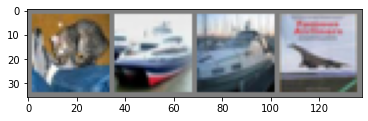

GroundTruth:   cat  ship  ship plane


In [ ]:
# 테스트 데이터 4개 출력

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images[:4], labels[:4]

imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:', ' '.join(['%5s' % classes[labels[j]] for j in range(4)]))

In [ ]:
# 모델 추론 결과 출력

outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join(['%5s' % classes[predicted[j]] for j in range(4)]))

Predicted:   cat truck  ship  ship


In [ ]:
# 정확도 계산

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


In [ ]:
# 클래스 별 정확도 계산

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        c = (predicted == labels).squeeze()
        for i in range(len(c)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82 %
Accuracy of   car : 82 %
Accuracy of  bird : 58 %
Accuracy of   cat : 63 %
Accuracy of  deer : 78 %
Accuracy of   dog : 48 %
Accuracy of  frog : 86 %
Accuracy of horse : 77 %
Accuracy of  ship : 88 %
Accuracy of truck : 95 %
